### Load Necessary Libraries

In [84]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from ruptures import Binseg
from typing import List, Optional, Tuple
from sklearn.ensemble import RandomForestRegressor
import shap
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance

from stock_price_prediction.types import TickerSymbol
from stock_price_prediction.stock_model import StockModel
from stock_price_prediction.data_helper import DataHelper

### Select a stock ticker for example analysis

In [9]:
ticker = TickerSymbol.UPS

## Fetch Raw Stock Data

In [29]:
# Define a function to download stock price history
def fetch_stock_history(
    tickers: List[TickerSymbol],
    start_date: dt.date = dt.date(1950, 1, 1),
    end_date: dt.date = dt.date(2025, 1, 1),
) -> pd.DataFrame:
    stock_history = yf.download(
        tickers=[ticker.name for ticker in tickers],
        start=start_date,
        end=end_date,
        auto_adjust=False,
        actions=True,
        multi_level_index=False,
        progress=False,
    )
    return stock_history

# Load stock data
# Use an old date as start date to be sure to download all the stock history.
start_date = dt.date(1900, 1, 1)
end_date = dt.date.today()

raw_data = fetch_stock_history(tickers=[ticker], start_date=start_date, end_date=end_date)

# Display the last 5 rows. We should see several prices - features.
# Yahoo Finance provides these features (with parameters specified in yf.download() method):
# Adj Close, Close, Dividends, High, Low, Open, Stock Splits and Volume
display(raw_data.tail())

,Adj Close,Close,Dividends,High,Low,Open,Stock Splits,Volume
Date,,,,,,,,
2025-02-25,118.110001,118.110001,0.0,118.339996,116.459999,116.459999,0.0,4985600
2025-02-26,116.889999,116.889999,0.0,118.570000,116.720001,118.099998,0.0,3445300
2025-02-27,117.629997,117.629997,0.0,118.730003,116.989998,117.000000,0.0,4821600
2025-02-28,119.029999,119.029999,0.0,119.629997,117.800003,117.800003,0.0,8754900
2025-03-03,119.260002,119.260002,0.0,120.980003,118.769997,119.820000,0.0,5162500


### Visualize data

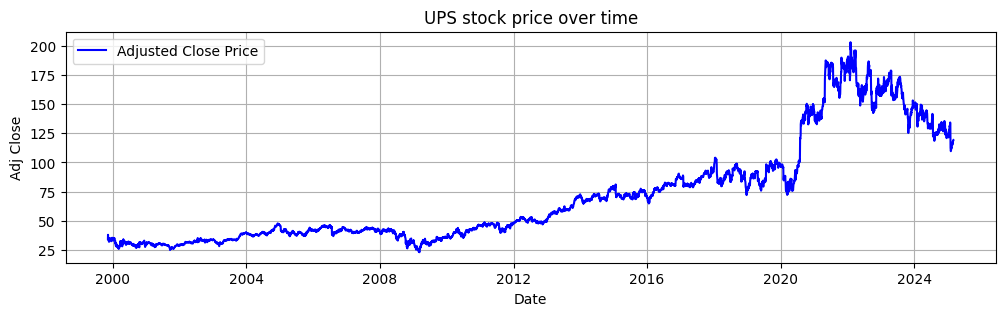

In [62]:
plt.figure(figsize=(12, 3))
plt.plot(raw_data.index, raw_data["Adj Close"], label="Adjusted Close Price", color="blue")
plt.xlabel("Date")
plt.ylabel("Adj Close")
plt.title(f"{ticker.name} stock price over time")
plt.legend()
plt.grid()
plt.show()

## Preprocess the data

Extract other features from already existing features, think about what might come in use, analyze correlations.

- The preprocessing function performs several important steps:
- Returns Calculation – Measures daily percentage changes.
- Moving Averages (MA_10, MA_50) – Tracks short-term & long-term trends.
- Volatility (Rolling Std Dev of Returns) – Helps identify risk levels.
- Relative Strength Index (RSI) – Measures market momentum.
- Lag Features – Adds past returns as features to detect patterns.
- One-Hot Encoding of Weekdays – Helps models account for day-based trends.

In [52]:
def preprocess_stock_history(stock_history: pd.DataFrame) -> pd.DataFrame:
    stock_history = stock_history[
        [
            "Open",
            "High",
            "Low",
            "Close",
            "Adj Close",
            "Volume",
            "Dividends",
            "Stock Splits",
        ]
    ]
    stock_history = stock_history.dropna()

    # Calculate returns
    stock_history["Returns"] = stock_history["Adj Close"].pct_change()

    # Moving Averages
    stock_history["MA_10"] = stock_history["Adj Close"].rolling(window=10).mean()
    stock_history["MA_50"] = stock_history["Adj Close"].rolling(window=50).mean()

    # Volatility - Rolling standard deviation of returns (10-day window)
    stock_history["Volatility_10"] = (
        stock_history["Returns"].rolling(window=10).std()
    )

    # RSI Calculation (Relative Strength Index with 14-day window)
    delta = stock_history["Adj Close"].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    stock_history["RSI_14"] = 100 - (100 / (1 + rs))

    # Lagged Returns (1-day, 5-day, 10-day)
    stock_history["Lag_1"] = stock_history["Returns"].shift(1)
    stock_history["Lag_5"] = stock_history["Returns"].shift(5)
    stock_history["Lag_10"] = stock_history["Returns"].shift(10)

    # Drop missing values due to rolling window calculations
    stock_history = stock_history.dropna()

    # Set data frequency to business days and interpolate newly added nan values.
    stock_history = stock_history.asfreq("B").interpolate()

    # One-hot encoding for day of the week
    stock_history["DayOfWeek"] = stock_history.index.dayofweek
    stock_history = pd.get_dummies(
        stock_history, columns=["DayOfWeek"], drop_first=True
    )
    return stock_history

preprocessed_data = preprocess_stock_history(stock_history=raw_data)

# View the preprocessed data - dropped of nan values and with added features that might help us to predict Adj Close price.
display(preprocessed_data)

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,Returns,MA_10,MA_50,Volatility_10,RSI_14,Lag_1,Lag_5,Lag_10,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4
Date,,,,,,,,,,,,,,,,,,,,
2000-01-21,68.875000,68.875000,66.687500,67.250000,34.173458,1270100.0,0.0,0.0,-0.023594,34.376734,34.213430,0.019679,45.172317,0.009158,0.013915,0.000000,False,False,False,True
2000-01-24,67.875000,68.250000,66.000000,66.000000,33.538284,831400.0,0.0,0.0,-0.018587,34.357680,34.193707,0.019052,46.953454,-0.023594,0.010979,-0.023898,False,False,False,False
2000-01-25,65.625000,66.625000,64.750000,65.875000,33.474785,1263000.0,0.0,0.0,-0.001893,34.297339,34.104424,0.018674,53.036538,-0.018587,-0.005430,0.010358,True,False,False,False
2000-01-26,65.250000,65.625000,64.500000,65.125000,33.093655,933400.0,0.0,0.0,-0.011386,34.290988,34.053045,0.016879,39.047673,-0.001893,-0.006369,-0.027027,False,True,False,False
2000-01-27,65.312500,65.375000,64.000000,65.125000,33.093655,1128400.0,0.0,0.0,0.000000,34.176654,34.016842,0.012442,39.047673,-0.011386,0.009158,0.032567,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-25,116.459999,118.339996,116.459999,118.110001,118.110001,4985600.0,0.0,0.0,0.016787,115.176970,121.585039,0.007460,86.386192,-0.001461,0.007331,0.009283,True,False,False,False
2025-02-26,118.099998,118.570000,116.720001,116.889999,116.889999,3445300.0,0.0,0.0,-0.010329,115.574585,121.376880,0.008885,77.436739,0.016787,-0.003639,0.003241,False,True,False,False
2025-02-27,117.000000,118.730003,116.989998,117.629997,117.629997,4821600.0,0.0,0.0,0.006331,116.072819,121.186281,0.008671,75.803935,-0.010329,0.013913,-0.002357,False,False,True,False


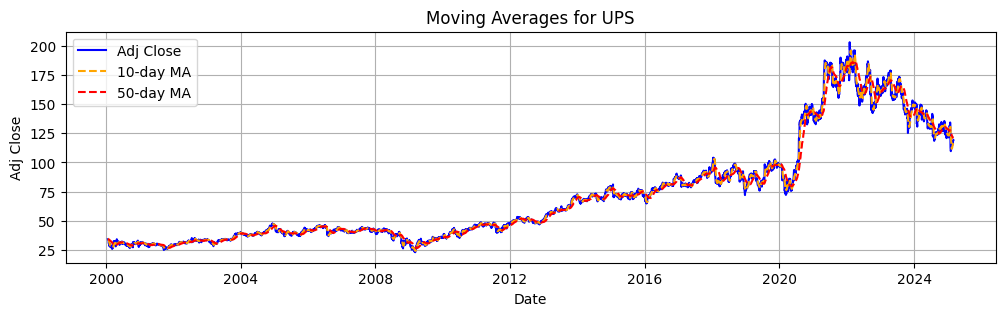

In [65]:
# Plot Moving Averages
plt.figure(figsize=(12, 3))
plt.plot(preprocessed_data.index, preprocessed_data["Adj Close"], label="Adj Close", color="blue")
plt.plot(preprocessed_data.index, preprocessed_data["MA_10"], label="10-day MA", linestyle="dashed", color="orange")
plt.plot(preprocessed_data.index, preprocessed_data["MA_50"], label="50-day MA", linestyle="dashed", color="red")
plt.xlabel("Date")
plt.ylabel("Adj Close")
plt.title(f"Moving Averages for {ticker.name}")
plt.legend()
plt.grid()
plt.show()

## Analyze features for their importance

#### Correlation

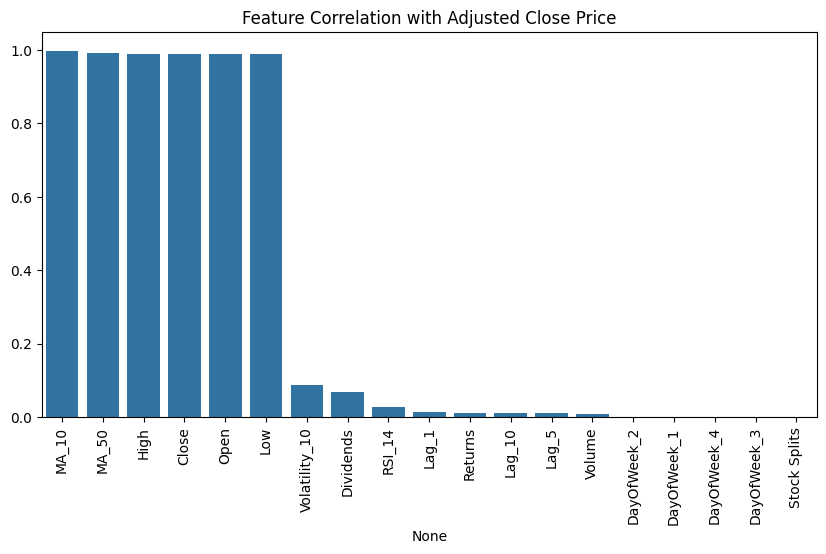

In [80]:
correlation_matrix = preprocessed_data.corr()
corr_with_adj_close = correlation_matrix["Adj Close"].drop("Adj Close").abs().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=corr_with_adj_close.index, y=corr_with_adj_close.values)
plt.xticks(rotation=90)
plt.title("Feature Correlation with Adjusted Close Price")
plt.show()

We can see that moving averages and high, close, open and low prices are highly correlated with Adj Close (as expected). We also see that days of the week have nearly no correlation with the adjusted close price. The same goes for stock splits (which are basically just random scattered values for the model) and volume (that is a but surprising). Also returns (and therefore neither its lags) have significant impact on the adj close price.

What comes in the question is volatility and dividends.

#### Random Forest Model feature importance

In [81]:
X = preprocessed_data.drop(columns=["Adj Close"])
y = preprocessed_data["Adj Close"]

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X, y)

RandomForestRegressor(random_state=42)

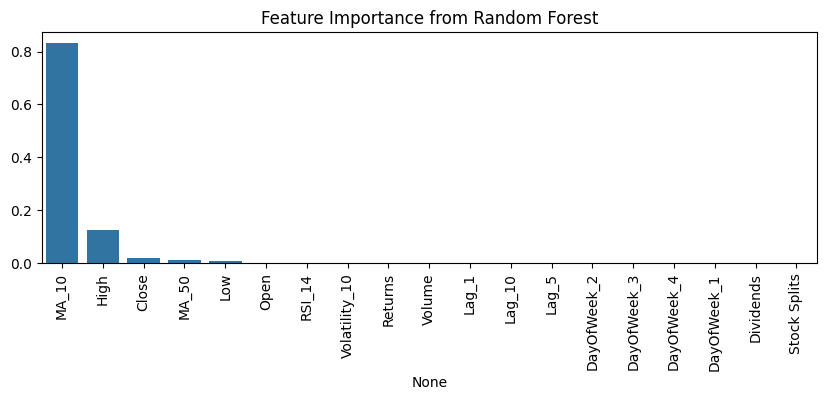

In [89]:
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 3))
sns.barplot(x=feature_importance.index, y=feature_importance.values)
plt.xticks(rotation=90)
plt.title("Feature Importance from Random Forest")
plt.show()

Based on random forest model, only 10 days moving average has significant impact. High and close prices are very low, others are totally unsignificant.

#### SHAP values from Random Forest Model

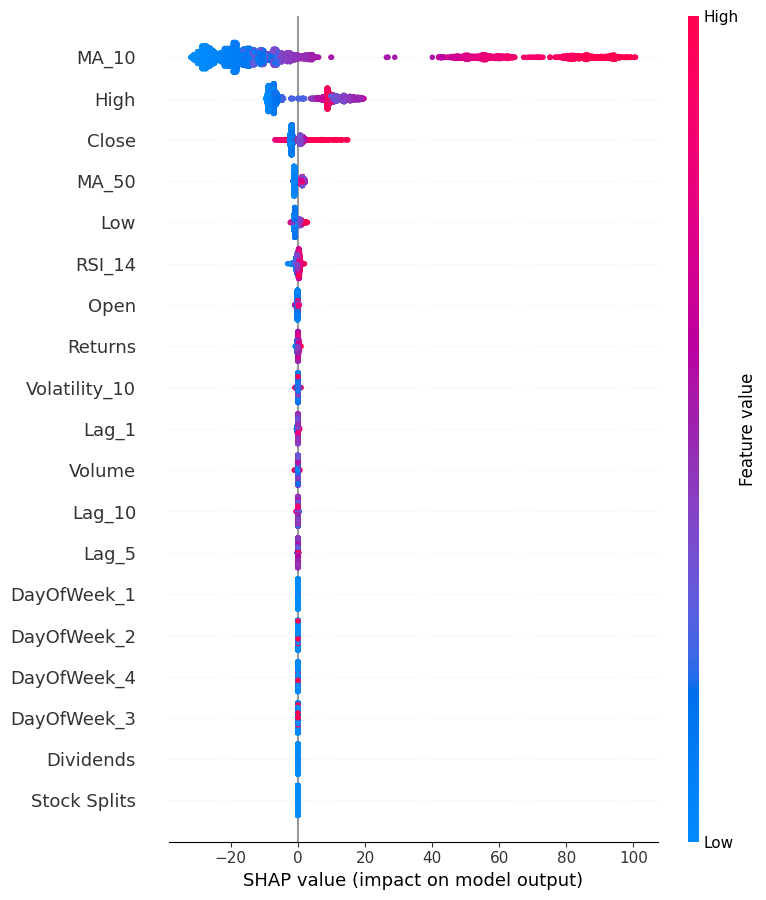

In [ ]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

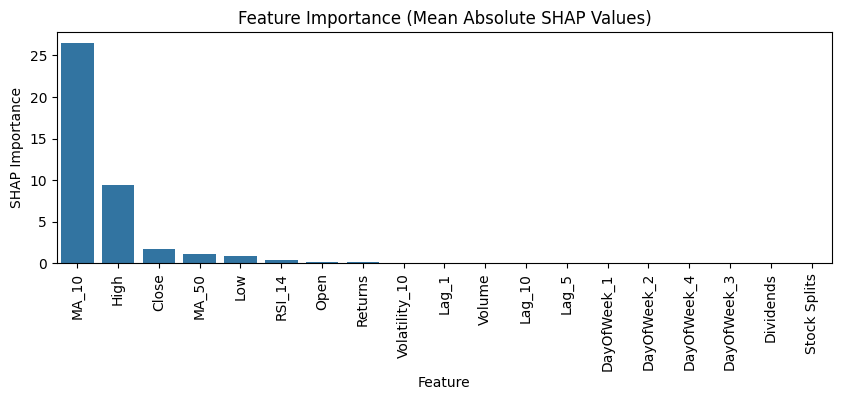

In [96]:
shap_importance = np.abs(shap_values).mean(axis=0)
shap_importance_df = pd.DataFrame(
    {"Feature": X.columns, "SHAP Importance": shap_importance}
).sort_values(by="SHAP Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 3))
sns.barplot(x=shap_importance_df["Feature"], y=shap_importance_df["SHAP Importance"])
plt.xticks(rotation=90)
plt.title("Feature Importance (Mean Absolute SHAP Values)")
plt.show()

Based on SHAP values we see significance in moving averages on 10 days, and high and close price.

#### Permutation importance

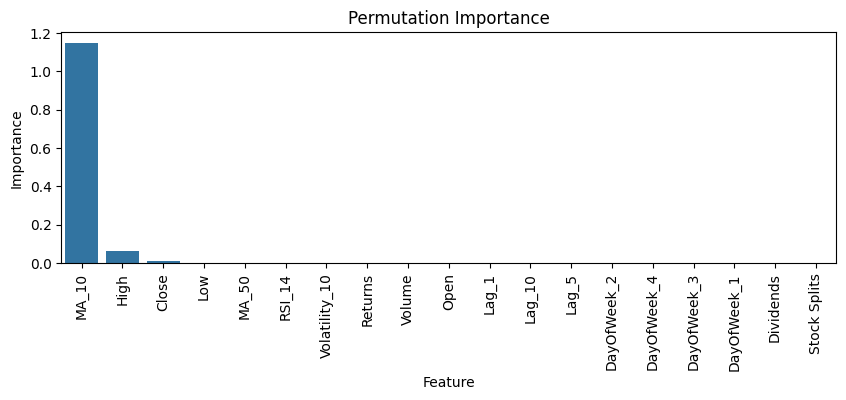

In [88]:
perm_importance = permutation_importance(rf_model, X, y, n_repeats=10, random_state=42)
perm_importance_df = pd.DataFrame(
    {"Feature": X.columns, "Importance": perm_importance.importances_mean}
).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 3))
sns.barplot(x=perm_importance_df["Feature"], y=perm_importance_df["Importance"])
plt.xticks(rotation=90)
plt.title("Permutation Importance")
plt.show()

Permutation importance from scikit-learn gives us basically the same results as the importance from random forest model.

### Conclusion on features

Comparing results from multiple analyses on feature importance, I've decided to use these following features for the neural network model:
- Close
- High
- Low
- MA_10
- MA_50

In [98]:
preprocessed_data = preprocessed_data[["Adj Close", "Close", "High", "Low", "MA_10", "MA_50"]]

## Breakpoint detection

In [99]:
def detect_breakout_point(prices: pd.Series) -> pd.Timestamp:
    data_reshaped = np.array(prices).reshape(-1, 1)
    binseg_model = Binseg(model="l2").fit(data_reshaped)
    change_points = binseg_model.predict(n_bkps=1)

    return prices.index[min(change_points)]

new_start_date = detect_breakout_point(
    prices=preprocessed_data["Adj Close"]
).replace(month=1, day=1)
preprocessed_data_cut = preprocessed_data[preprocessed_data.index >= new_start_date]

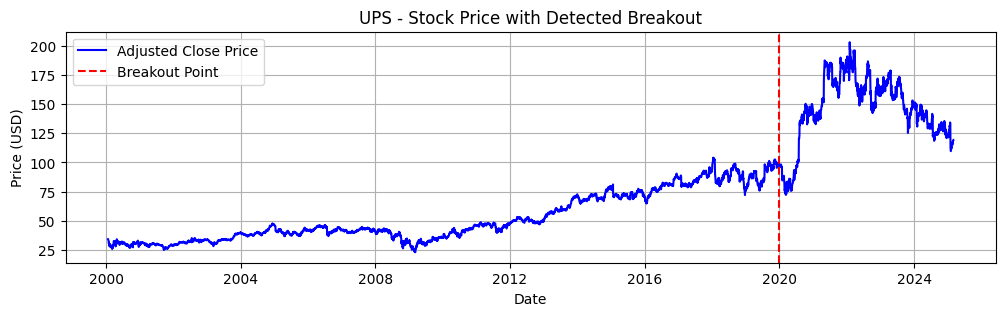

In [103]:
plt.figure(figsize=(12, 3))
plt.plot(preprocessed_data.index, preprocessed_data["Adj Close"], label="Adjusted Close Price", color="blue")
plt.axvline(x=new_start_date, color="red", linestyle="dashed", label="Breakout Point")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title(f"{ticker.name} - Stock Price with Detected Breakout")
plt.legend()
plt.grid()
plt.show()

In [100]:
preprocessed_data_cut

,Adj Close,Close,High,Low,MA_10,MA_50
Date,,,,,,
2020-01-01,96.993877,116.924999,117.529999,115.400002,97.985179,98.464622
2020-01-02,96.881889,116.790001,117.970001,115.230003,97.840009,98.457878
2020-01-03,96.823830,116.720001,116.860001,114.839996,97.737978,98.483067
2020-01-06,96.392456,116.199997,116.230003,114.370003,97.542207,98.515268
2020-01-07,96.226562,116.000000,116.440002,115.070000,97.426073,98.562918
...,...,...,...,...,...,...
2025-02-25,118.110001,118.110001,118.339996,116.459999,115.176970,121.585039
2025-02-26,116.889999,116.889999,118.570000,116.720001,115.574585,121.376880
2025-02-27,117.629997,117.629997,118.730003,116.989998,116.072819,121.186281
